In [1]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## CSV to KG (.ttl) ~ 1 minute

In [2]:
from rdflib import Graph
from rdflib import BNode, Literal
from rdflib import Namespace
from rdflib.namespace import RDF, RDFS, XSD
import pandas as pd
from sklearn.model_selection import train_test_split
import os

📁 CSV File Descriptions for PPI Knowledge Graph

* **`idx2entityid.csv`**
  Maps numerical indices to biological entities. These entities are either **UniProt protein IDs** (e.g., `Q8NBZ0`) or **Gene Ontology (GO) term IDs** (e.g., `GO_0047049`).

  ➤ **Columns:**

  * `index`: Integer identifier
  * `uniprot`: Protein or GO term ID

---

* **`idx_ppis.csv`**
  Encodes **protein-protein interactions** using index references. Each row represents a known interaction between two proteins.

  ➤ **Columns:**

  * `p1`: Index of the first protein
  * `p2`: Index of the second protein

---

* **`idx_positive_annotations.csv`**
  Links proteins to **functional GO terms**. These annotations describe biological processes or molecular functions associated with each protein.

  ➤ **Columns:**

  * `protein`: Index of the protein
  * `go_term`: Index of the associated GO term

---

* **`idx_go_links.csv`**
  Represents hierarchical or semantic relationships **between GO terms** (e.g., subclass relationships).

  ➤ **Columns:**

  * `go1`: Index of a GO term
  * `go2`: Index of a related GO term (e.g., a parent term)


In [3]:
RANDOM_STATE = 42

# Load CSVs
entity_map  = pd.read_csv("./dataset_KG_PPI_noNEG/idx2entityid.csv", header=None, names=["index", "uniprot"])
ppis        = pd.read_csv("./dataset_KG_PPI_noNEG/idx_ppis.csv", header=None, names=["p1", "p2"])
annotations = pd.read_csv("./dataset_KG_PPI_noNEG/idx_positive_annotations.csv", header=None, names=["protein", "go_term"])
go_links    = pd.read_csv("./dataset_KG_PPI_noNEG/idx_go_links.csv", header=None, names=["go1", "go2"])

# Remove duplicated links/edges
ppis.drop_duplicates(subset=["p1", "p2"], inplace=True)
annotations.drop_duplicates(subset=["protein", "go_term"], inplace=True)
go_links.drop_duplicates(subset=["go1", "go2"], inplace=True)

# Split PPIs
train_ppis, test_ppis = train_test_split(ppis, test_size=0.2, random_state=RANDOM_STATE)
val_ppis, test_ppis = train_test_split(test_ppis, test_size=0.5, random_state=RANDOM_STATE)
    
# Create graph and namespaces
graph = Graph()
BASE = "http://www.semanticweb.org/group_8/ppi_kg_2025/"
LAB = Namespace(BASE)

# Prefixes for URIs
graph.bind("lab", LAB)
bnode = BNode() # a GUID is generated

''' ------------------------------------ INDEXES ------------------------------------ '''

# Convert protein/GO index to entity ID for easier lookup
index_to_uniprot = {}
index_to_GO = {}

for idx, uid in zip(entity_map["index"], entity_map["uniprot"]):
    # Filter out malformed entity IDs (e.g., lines with long descriptions)
    if isinstance(uid, str) and len(uid) <= 11:
        if uid.startswith("GO"):
            index_to_GO[idx] = uid
        else:
            index_to_uniprot[idx] = uid

''' ------------------------------------ NODES ------------------------------------ '''

# Add Protein individuals
for idx, uniprot_id in index_to_uniprot.items():
    protein_uri = LAB[f"Protein_{uniprot_id}"]
    graph.add((protein_uri, RDF.type, LAB.Protein))
    graph.add((protein_uri, LAB.uniprotId, Literal(f"Protein_{uniprot_id}", datatype=XSD.string)))

# Add GO individuals
for idx, go_id in index_to_GO.items():
    go_uri = LAB[f"{go_id}"]
    graph.add((go_uri, RDF.type, LAB.GO_Term))
    graph.add((go_uri, LAB.goId, Literal(go_id, datatype=XSD.string)))

''' ------------------------------------ EDGES/LINKS ------------------------------------ '''

# Add only training PPI edges to the graph
for row in train_ppis.itertuples(index=False):
    if row.p1 in index_to_uniprot and row.p2 in index_to_uniprot:
        p1_uri = LAB[f"Protein_{index_to_uniprot[row.p1]}"]
        p2_uri = LAB[f"Protein_{index_to_uniprot[row.p2]}"]
        graph.add((p1_uri, LAB.interactsWith, p2_uri))

# Annotate proteins with GO terms
for row in annotations.itertuples(index=False):
    if row.protein in index_to_uniprot and row.go_term in index_to_GO:
        protein_uri = LAB[f"Protein_{index_to_uniprot[row.protein]}"]
        go_uri = LAB[f"{index_to_GO[row.go_term]}"]
        graph.add((protein_uri, LAB.annotatedWith, go_uri))

# Add GO-to-GO relationships
for row in go_links.itertuples(index=False):
    if row.go1 in index_to_GO and row.go2 in index_to_GO:
        go1_uri = LAB[f"{index_to_GO[row.go1]}"]
        go2_uri = LAB[f"{index_to_GO[row.go2]}"]
        graph.add((go1_uri, RDFS.subClassOf, go2_uri))

# Save graph
print("Saving graph to 'ppi_kg_2025.ttl':")
#print(graph.serialize(format="turtle"))
graph.serialize(destination="ppi_kg_2025.ttl", format="ttl")


Saving graph to 'ppi_kg_2025.ttl':


<Graph identifier=N14aeda0084fa4f0680f754df3826c689 (<class 'rdflib.graph.Graph'>)>

In [4]:
print(f"All interactions (100%): {len(ppis)}")
print(f"Train interactions ({len(train_ppis) / len(ppis) * 100:.0f}%): {len(train_ppis)}")
print(f"Validation interactions ({len(val_ppis) / len(ppis) * 100:.0f}%): {len(val_ppis)}")
print(f"Test interactions ({len(test_ppis) / len(ppis) * 100:.0f}%): {len(test_ppis)}")
print(f"Known proteins: {len(index_to_uniprot)}")

All interactions (100%): 215278
Train interactions (80%): 172222
Validation interactions (10%): 21528
Test interactions (10%): 21528
Known proteins: 12882


# Embeddings ~ 6 minutes (generating)

In [5]:
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.rdf2vec import RDF2VecTransformer
import numpy as np

In [6]:
# Check if embeddings already exist and only execute the rest of the code if they don't
if os.path.exists("ppi_kg_2025_embeddings.npy"):
    print("Embeddings already exist. Skipping generation.")
    embeddings = np.load("ppi_kg_2025_embeddings.npy")

else:
    # Step 1: Load RDF graph
    kg = KG("ppi_kg_2025.ttl", fmt="ttl")

    # Step 2: Load protein entities
    protein_entities = [
        f"http://www.semanticweb.org/group_8/ppi_kg_2025/Protein_{uniprot}"
        for uniprot in index_to_uniprot.values()
    ]

    # Step 3: Set up RDF2Vec
    walker = RandomWalker(max_depth=2, random_state=RANDOM_STATE, n_jobs=4)
    embedder = Word2Vec(workers=1, epochs=1)
    transformer = RDF2VecTransformer(walkers=[walker], embedder=embedder)

    # Step 4: Generate embeddings
    print("Generating embeddings...")
    embeddings = transformer.fit_transform(kg, protein_entities)

    # Step 5: Save embeddings
    embeddings = np.array(embeddings[0])
    np.save("ppi_kg_2025_embeddings.npy", embeddings)
    print("Embeddings saved to 'ppi_kg_2025_embeddings.npy'.")

print("Embedding shape:\n\t", embeddings.shape, "(Samples, Dimensionality)")

Generating embeddings...
Embeddings saved to 'ppi_kg_2025_embeddings.npy'.
Embedding shape:
	 (12882, 100) (Samples, Dimensionality)


In [7]:
print("Printing first protein embedding as an example!")
print(f"Protein idx {0}:\n {embeddings[0]}")

Printing first protein embedding as an example!
Protein idx 0:
 [ 0.00037005 -0.00251245 -0.01157265  0.0278947  -0.0063453  -0.01643709
  0.01458247  0.01337874  0.01159336 -0.02244975 -0.0130516  -0.01991686
 -0.00794842  0.01647655 -0.01987859  0.0032126  -0.00884461 -0.00307762
 -0.01117525  0.01812315 -0.00092934  0.00959343  0.00252355 -0.01415322
  0.00692491  0.01745225 -0.01868016  0.01219592  0.0103939  -0.01068232
  0.00984772 -0.00512911 -0.00651532  0.00865764  0.01482249  0.00118563
 -0.00544732  0.00954335 -0.01368915  0.01772493  0.00183193 -0.00840475
  0.00374381 -0.00758561 -0.00934879 -0.00611634 -0.01441868 -0.0038364
  0.01414947 -0.00496433 -0.00620876 -0.00415258 -0.00837862  0.01226434
  0.00573241  0.01886391 -0.01035365 -0.01184741  0.00934154 -0.00584721
 -0.01616438  0.00659151 -0.00577914 -0.00732263  0.01107796 -0.00849225
 -0.00017414  0.00881632 -0.02017657  0.01469873 -0.01362861  0.0087835
  0.0126752   0.0059915  -0.00320611 -0.00353923 -0.01838904  

# t-SNE w/ Clustering ~ 1 minutes

In [8]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.manifold")

In [9]:
# t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
embeddings_2d = tsne.fit_transform(embeddings)

# Cluster
kmeans = KMeans(n_clusters=10, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(embeddings)


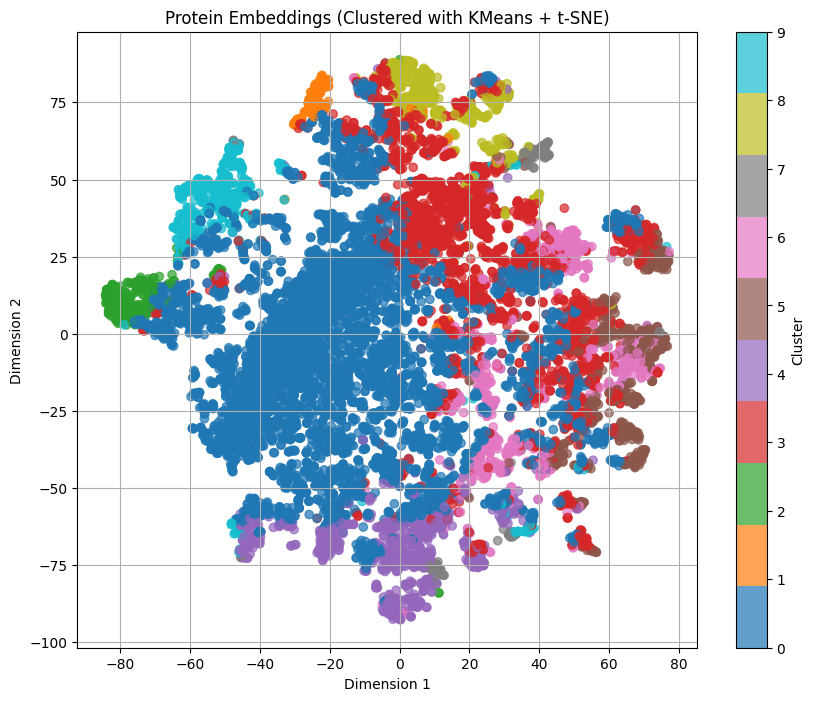

In [10]:
# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, alpha=0.7, cmap='tab10')
plt.title("Protein Embeddings (Clustered with KMeans + t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()


# GNN

### Generating negative samples & preprocessing data
~ 2 minutes (random) ~ 26 minutes (candidates) ~ > 1 hour (full)

In [11]:
import random
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.metrics.pairwise import cosine_similarity

We can use 1 of these 3 following functions to sample negative edges (negative links) that are not already in existing edges (positive links).

Later we will compare the results of using each technique!

Sure! Here's the revised version with a brief introduction and a clear table:

---

**To ensure we can create a balanced train set, we have the following 3 points we need to considerate:**

| Priority | Description                                                                                      | Motive |
| -------- | ------------------------------------------------------------------------------------------------ | ----- |
| High     | Ensure that **each protein** has approximately the **same number of positive** and **negative edges**.       | Avoid bias per protein, making the model learn a balanced node structure |
| High     | Ensure that the total **number of negative edges** equals the total **number of positive edges**.        | Helps maintaining the dataset balanced. Also, the last point can help with this |
| Low      | Ensure that **each protein** has approximately the **same total number of edges** (positive + negative). | Good for uniformity, but not essential in practice, especially when trying to work with real connections, where normally some proteins could have more interactions than other nodes |


In [12]:
# Sample same number of random negative edges
def sample_random_negative_edges(num_samples, num_nodes, existing_edges):
    neg_edges = set()
    while len(neg_edges) < num_samples:
        i, j = random.randint(0, num_nodes-1), random.randint(0, num_nodes-1)
        if i != j and (i, j) not in existing_edges and (j, i) not in existing_edges:
            neg_edges.add((i, j))
    return torch.tensor(list(neg_edges), dtype=torch.long).t()

# Sample small number of candidates to avoid full similarity matrix
def sample_candidates_least_similar_negative_edges(num_samples, num_nodes, existing_edges, embeddings):
    candidates = []
    attempts = 0
    max_attempts = num_samples * 20  # Try up to 20x the number of samples
    while len(candidates) < num_samples * 5 and attempts < max_attempts:
        i, j = random.randint(0, num_nodes-1), random.randint(0, num_nodes-1)
        if i != j and (i, j) not in existing_edges and (j, i) not in existing_edges:
            candidates.append((i, j))
        attempts += 1

    # Compute cosine similarity only for sampled candidates
    emb = np.array(embeddings)
    sims = [cosine_similarity(emb[i].reshape(1, -1), emb[j].reshape(1, -1))[0, 0] for i, j in candidates]
    sorted_candidates = [pair for _, pair in sorted(zip(sims, candidates), key=lambda x: x[0])]

    # Select the least similar pairs
    neg_edges = sorted_candidates[:num_samples]
    return torch.tensor(neg_edges, dtype=torch.long).t()

# Sample negative edges based on least similarity
def sample_least_similar_negative_edges(num_samples, num_nodes, existing_edges, embeddings):
    # Compute cosine similarity between all protein embeddings
    similarity_matrix = cosine_similarity(embeddings)
    
    # Flatten the similarity matrix and sort by least similarity
    candidate_edges = [
        (i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j
    ]
    candidate_similarities = [
        similarity_matrix[i, j] for i, j in candidate_edges
    ]
    sorted_candidates = sorted(
        zip(candidate_edges, candidate_similarities),
        key=lambda x: x[1]
    )
    
    # Sample same number of edges with the least similarity that are not in existing edges
    neg_edges = set()
    for (i, j), _ in sorted_candidates:
        if (i, j) not in existing_edges and (j, i) not in existing_edges:
            neg_edges.add((i, j))
            if len(neg_edges) == num_samples:
                break
    
    return torch.tensor(list(neg_edges), dtype=torch.long).t()


**P1 interactsWith P2** is different from **P2 interactsWith P1**

In [13]:
# ---- Step 1: Setup ----
# Embeddings (INPUT)
x = torch.tensor(embeddings, dtype=torch.float)  # shape: [12882, 100]

''' ------------------------------------ TRAINING DATA ------------------------------------ '''
''' NOTE: SEE LAST CELL '''

''' ------------------------------------ VALIDATION DATA ------------------------------------ '''

# Build positive edge_index from known PPIs (shape: [2, num_edges])
positive_edges_val = torch.tensor([
    [row[0], row[1]] for row in val_ppis.itertuples(index=False)
    if row.p1 in index_to_uniprot and row.p2 in index_to_uniprot
], dtype=torch.long).t().contiguous()

# Prepare validation positives and negatives for link prediction
existing_edges_set = set([(i.item(), j.item()) for i, j in positive_edges_val.t()])
negative_edges_val = sample_random_negative_edges(positive_edges_val.size(1), x.size(0), existing_edges_set)
#negative_edges_train = sample_candidates_least_similar_negative_edges(positive_edges_train.size(1), x.size(0), existing_edges_set, x)
#negative_edges_train = sample_least_similar_negative_edges(positive_edges_train.size(1), x.size(0), existing_edges_set, x)

# Combine edges and labels
edge_label_index = torch.cat([positive_edges_val, negative_edges_val], dim=1)
# 0 for negative edges, 1 for positive edges
edge_label = torch.cat([torch.ones(positive_edges_val.size(1)), torch.zeros(negative_edges_val.size(1))], dim=0)

# Create PyG Data object
data_val = Data(x=x, edge_index=positive_edges_val)  # GCN still trains on real edges
data_val.edge_label_index = edge_label_index
data_val.edge_label = edge_label

print("\nVALIDATION DATA")
print("Positive edges:", positive_edges_val.size(1))
print(positive_edges_val)
print("Negative edges:", negative_edges_val.size(1))
print(negative_edges_val)
print("Total edges:", edge_label_index.size(1))
print(edge_label_index)

''' ------------------------------------ TEST DATA ------------------------------------ '''

# Build positive edge_index from known PPIs (shape: [2, num_edges])
positive_edges_test = torch.tensor([
    [row[0], row[1]] for row in test_ppis.itertuples(index=False)
    if row.p1 in index_to_uniprot and row.p2 in index_to_uniprot
], dtype=torch.long).t().contiguous()

# Prepare test positives and negatives for link prediction
existing_edges_set = set([(i.item(), j.item()) for i, j in positive_edges_test.t()])
negative_edges_test = sample_random_negative_edges(positive_edges_test.size(1), x.size(0), existing_edges_set)
#negative_edges_train = sample_candidates_least_similar_negative_edges(positive_edges_train.size(1), x.size(0), existing_edges_set, x)
#negative_edges_train = sample_least_similar_negative_edges(positive_edges_train.size(1), x.size(0), existing_edges_set, x)

# Combine edges and labels
edge_label_index = torch.cat([positive_edges_test, negative_edges_test], dim=1)
# 0 for negative edges, 1 for positive edges
edge_label = torch.cat([torch.ones(positive_edges_test.size(1)), torch.zeros(negative_edges_test.size(1))], dim=0)

data_test = Data(x=x, edge_index=positive_edges_test)  # GCN still trains on real edges
data_test.edge_label_index = edge_label_index
data_test.edge_label = edge_label

print("\nTESTING DATA")
print("Positive edges:", positive_edges_test.size(1))
print(positive_edges_test)
print("Negative edges:", negative_edges_test.size(1))
print(negative_edges_test)
print("Total edges:", edge_label_index.size(1))
print(edge_label_index)



VALIDATION DATA
Positive edges: 21528
tensor([[ 2532,  9093,  3059,  ...,  4569,  1343, 11649],
        [12487,  4741, 11193,  ..., 10763,  1690,  9673]])
Negative edges: 21528
tensor([[ 4913,  1114,  4006,  ...,  4396,  1556, 12666],
        [10270,  7826,   137,  ...,  7954, 12422,  1229]])
Total edges: 43056
tensor([[ 2532,  9093,  3059,  ...,  4396,  1556, 12666],
        [12487,  4741, 11193,  ...,  7954, 12422,  1229]])

TESTING DATA
Positive edges: 21528
tensor([[ 9910,  9100,  6548,  ...,  2211,  1435, 12146],
        [ 7198,  4277, 11059,  ...,  9251, 12302,   350]])
Negative edges: 21528
tensor([[ 2851,  7887,   381,  ...,  2078, 11188,   907],
        [ 5315,  9250,   392,  ...,  9284, 12206,  2208]])
Total edges: 43056
tensor([[ 9910,  9100,  6548,  ...,  2078, 11188,   907],
        [ 7198,  4277, 11059,  ...,  9284, 12206,  2208]])


![Coordinate-COO-format-illustration-8776.png](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.researchgate.net%2Fpublication%2F334536999%2Ffigure%2Fdownload%2Ffig3%2FAS%3A782115624976385%401563482304188%2FCoordinate-COO-format-illustration.png&f=1&nofb=1&ipt=a56fd7d8ce390057c62975067cc91f32891a706141c1e7069103b4fb92602493)

### Train & Evaluate Model

In [14]:
# ---- Step 2: GCN Model ----
class GCNEdgeClassifier(torch.nn.Module):
    def __init__(self, hidden_dim_1=200, hidden_dim_2=32):
        super().__init__()
        self.conv1 = GCNConv(100, hidden_dim_1) # 100: embedding size
        self.conv2 = GCNConv(hidden_dim_1, hidden_dim_2)
        self.edge_classifier = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim_2 * 2, 1), # (src + dst)
            # torch.nn.ReLU(),
            # torch.nn.Linear(32, 1)
        )

    def encode(self, x, edge_index):
        # x: [num_nodes, hidden_dim] -> [12882, 100]
        # edge_index: [2, num_edges] -> [2, 172222]
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        # z: [num_nodes, hidden_dim] -> [12882, 32]
        # edge_index: [2, num_edges] -> [2, 172222]
        src, dst = z[edge_index[0]], z[edge_index[1]]
        edge_features = torch.cat([src, dst], dim=1)  # [num_edges, 2 * hidden_dim]
        return self.edge_classifier(edge_features).view(-1) # [num_edges]

    def forward(self, data):
        z = self.encode(data.x, data.edge_index)
        return self.decode(z, data.edge_label_index)


In [15]:
from sklearn.metrics import classification_report, roc_auc_score
from tqdm.notebook import tqdm
from sklearn.model_selection import ParameterGrid

In [ ]:
# ---- Step 3: Train ----
def train_evaluate(params, data_train, data_test, data_val):
    model = GCNEdgeClassifier(params['hidden_dim1'], params['hidden_dim2']).to(DEVICE)
    data_train = data_train.to(DEVICE)
    data_test = data_test.to(DEVICE)
    data_val = data_val.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

    patience = params['epochs'] // 10
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_state_dict = None
    
    # Training loop
    model.train()
    for epoch in tqdm(range(params['epochs'])):
        optimizer.zero_grad()
        pred = model(data_train)
        loss = F.binary_cross_entropy_with_logits(pred, data_train.edge_label) # NOTE: DO NOT CHANGE THIS LOSS
        loss.backward()
        optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_logits = model(data_val)
            val_loss = F.binary_cross_entropy_with_logits(val_logits, data_val.edge_label)

        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Early stopping based on validation loss
        if best_state_dict is None or val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            epochs_no_improve = 0
            best_state_dict = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} (Val loss didn't improve for {patience} epochs)")
                break

    # Load best model weights
    if best_state_dict:
        model.load_state_dict(best_state_dict)
    
    # ---- Step 4: Evaluate ----
    model.eval()
    with torch.no_grad():
        logits = model(data_test)
        prob = torch.sigmoid(logits)
        pred = (prob >= 0.5).long()
    
    true = data_test.edge_label.cpu().numpy()
    prob = prob.cpu().numpy()
    pred = pred.cpu().numpy()

    # Accuracy
    auc = roc_auc_score(true, prob) # NOTE: DO NOT CHANGE THIS METRIC
    report = classification_report(true, pred, output_dict=True, zero_division=0) # zero_division=0 to avoid warnings
    
    # Full classification report
    print(f"Final ROC AUC: {auc:.4f}") # AUC Score (important for link prediction!)
    print(f"Final Classification Report: {report}")
    
    return auc, report


#### Metrics Meaning in the Project Context

|  Metrics  |Meaning|
|-----------|-------|
| Accuracy | Proportion of all predicted interactions and non-interactions that were correct.|
| Precision | Of the predicted interacting protein pairs, how many actually interact (High precision = fewer false positives). |
| Recall | Of the actual interacting protein pairs, how many did the model correctly identify (High recall = fewer false negatives). |
| F1-score | Mean of precision and recall. |
| Support | Number of true positives or true negatives in the dataset. |
| ROC AUC | This metric tells how well the model ranks interacting vs non-interacting pairs, regardless of threshold. |
   

Metrics conclusion: AUC is a key benchmark for comparing models, since it handles ranking well; Precision/Recall/F1 depends on what's more costly: false positives (bad predictions of interaction) or false negatives (missing a real interaction); Accuracy isn't enough because imbalanced data will make it misleading.

### Comparing methods of generating negatives using Grid Search
~ 20 minutes

In [17]:
# Define hyperparameter grid
param_grid = {
    'hidden_dim1': [128, 256],
    'hidden_dim2': [16, 32],
    'lr': [0.001, 0.01, 0.05],
    'epochs': [150]
}

# Define negative sampling methods
negative_sampling_methods = {
    "Random": sample_random_negative_edges,
    "Candidates": sample_candidates_least_similar_negative_edges
}

# (2 * 2 * 3 * 1) * 2 = 24 combinations
all_results = []

# Build positive edge_index from known PPIs (shape: [2, num_edges])
positive_edges_train = torch.tensor([
    [row[0], row[1]] for row in train_ppis.itertuples(index=False)
    if row.p1 in index_to_uniprot and row.p2 in index_to_uniprot
], dtype=torch.long).t().contiguous()

print("Starting negative sampling method comparison...")
for method_name, neg_sampler in negative_sampling_methods.items():
    print(f"\n--- Testing negative sampling method: {method_name} ---")

    # Generate training negatives
    existing_edges_train = set([(i.item(), j.item()) for i, j in positive_edges_train.t()])
    if method_name == "Random":
        negative_edges_train = neg_sampler(positive_edges_train.size(1), x.size(0), existing_edges_train)
    else:
        negative_edges_train = neg_sampler(positive_edges_train.size(1), x.size(0), existing_edges_train, x)

    edge_label_index_train = torch.cat([positive_edges_train, negative_edges_train], dim=1)
    edge_label_train = torch.cat([
        torch.ones(positive_edges_train.size(1)), 
        torch.zeros(negative_edges_train.size(1))
    ], dim=0)

    data_train_method = Data(x=x, edge_index=positive_edges_train)
    data_train_method.edge_label_index = edge_label_index_train
    data_train_method.edge_label = edge_label_train

    best_auc = 0
    best_params = None

    print("Starting grid search...")
    for params in ParameterGrid(param_grid):
        print(f"\nTesting params: {params}")
        auc, report = train_evaluate(params, data_train_method, data_test, data_val)

        all_results.append({
            'method': method_name,
            'auc': auc,
            '0.0 - precision': report['0.0']['precision'],
            '0.0 - recall': report['0.0']['recall'],
            '0.0 - f1-score': report['0.0']['f1-score'],
            '0.0 - support': report['0.0']['support'],
            '1.0 - precision': report['1.0']['precision'],
            '1.0 - recall': report['1.0']['recall'],
            '1.0 - f1-score': report['1.0']['f1-score'],
            '1.0 - support': report['1.0']['support'],
            'macro avg - precision': report['macro avg']['precision'],
            'macro avg - recall': report['macro avg']['recall'],
            'macro avg - f1-score': report['macro avg']['f1-score'],
            'macro avg - support': report['macro avg']['support'],
            'weighted avg - precision': report['weighted avg']['precision'],
            'weighted avg - recall': report['weighted avg']['recall'],
            'weighted avg - f1-score': report['weighted avg']['f1-score'],
            'weighted avg - support': report['weighted avg']['support'],
            **params
        })

        if auc > best_auc:
            best_auc = auc
            best_params = params

    print(f"\nBest AUC for method '{method_name}': {best_auc} with params: {best_params}")

# Save all results to CSV
results_df = pd.DataFrame(all_results)
results_df.to_csv('grid_search_results.csv', index=False)
print("\n-----------------------------------------")
print("Results saved to 'grid_search_results.csv'")
print(results_df.to_string(index=False))


Starting negative sampling method comparison...

--- Testing negative sampling method: Random ---
Starting grid search...

Testing params: {'epochs': 150, 'hidden_dim1': 128, 'hidden_dim2': 16, 'lr': 0.001}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6363 | Val Loss: 0.6464
Epoch 20 | Train Loss: 0.6235 | Val Loss: 0.6277
Epoch 30 | Train Loss: 0.6161 | Val Loss: 0.6199
Epoch 40 | Train Loss: 0.6072 | Val Loss: 0.6109
Epoch 50 | Train Loss: 0.5974 | Val Loss: 0.6000
Epoch 60 | Train Loss: 0.5867 | Val Loss: 0.5886
Epoch 70 | Train Loss: 0.5750 | Val Loss: 0.5782
Epoch 80 | Train Loss: 0.5627 | Val Loss: 0.5695
Epoch 90 | Train Loss: 0.5513 | Val Loss: 0.5663
Epoch 100 | Train Loss: 0.5415 | Val Loss: 0.5660
Epoch 110 | Train Loss: 0.5326 | Val Loss: 0.5648
Epoch 120 | Train Loss: 0.5241 | Val Loss: 0.5628
Epoch 130 | Train Loss: 0.5159 | Val Loss: 0.5614
Epoch 140 | Train Loss: 0.5087 | Val Loss: 0.5628
Early stopping at epoch 142 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8103
Final Classification Report: {'0.0': {'precision': 0.7690248172175883, 'recall': 0.6937941285767373, 'f1-score': 0.7294749694749696, 'support': 21528}, '1.0': {'precision': 0.7210798002877211, 'recall': 0.79162021553325

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6106 | Val Loss: 0.6188
Epoch 20 | Train Loss: 0.5677 | Val Loss: 0.5721
Epoch 30 | Train Loss: 0.5133 | Val Loss: 0.5336
Epoch 40 | Train Loss: 0.4679 | Val Loss: 0.5208
Epoch 50 | Train Loss: 0.4446 | Val Loss: 0.5235
Epoch 60 | Train Loss: 0.4386 | Val Loss: 0.5175
Early stopping at epoch 69 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8431
Final Classification Report: {'0.0': {'precision': 0.7931240360216926, 'recall': 0.7404775176514307, 'f1-score': 0.7658971340716361, 'support': 21528}, '1.0': {'precision': 0.7566319641068083, 'recall': 0.8068561872909699, 'f1-score': 0.7809373946274024, 'support': 21528}, 'accuracy': 0.7736668524712003, 'macro avg': {'precision': 0.7748780000642504, 'recall': 0.7736668524712003, 'f1-score': 0.7734172643495192, 'support': 43056}, 'weighted avg': {'precision': 0.7748780000642504, 'recall': 0.7736668524712003, 'f1-score': 0.7734172643495192, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 128,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6491 | Val Loss: 0.6602
Epoch 20 | Train Loss: 0.5501 | Val Loss: 0.5677
Epoch 30 | Train Loss: 0.4574 | Val Loss: 0.5268
Epoch 40 | Train Loss: 0.4509 | Val Loss: 0.5397
Early stopping at epoch 41 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8375
Final Classification Report: {'0.0': {'precision': 0.7845422711355677, 'recall': 0.7284931252322556, 'f1-score': 0.7554795510381039, 'support': 21528}, '1.0': {'precision': 0.7465967224486257, 'recall': 0.7999349684132293, 'f1-score': 0.7723460555231646, 'support': 21528}, 'accuracy': 0.7642140468227425, 'macro avg': {'precision': 0.7655694967920967, 'recall': 0.7642140468227425, 'f1-score': 0.7639128032806343, 'support': 43056}, 'weighted avg': {'precision': 0.7655694967920966, 'recall': 0.7642140468227425, 'f1-score': 0.7639128032806343, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 128, 'hidden_dim2': 32, 'lr': 0.001}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6514 | Val Loss: 0.6586
Epoch 20 | Train Loss: 0.6337 | Val Loss: 0.6371
Epoch 30 | Train Loss: 0.6246 | Val Loss: 0.6265
Epoch 40 | Train Loss: 0.6149 | Val Loss: 0.6182
Epoch 50 | Train Loss: 0.6038 | Val Loss: 0.6047
Epoch 60 | Train Loss: 0.5911 | Val Loss: 0.5913
Epoch 70 | Train Loss: 0.5763 | Val Loss: 0.5771
Epoch 80 | Train Loss: 0.5607 | Val Loss: 0.5660
Epoch 90 | Train Loss: 0.5464 | Val Loss: 0.5607
Epoch 100 | Train Loss: 0.5342 | Val Loss: 0.5591
Epoch 110 | Train Loss: 0.5232 | Val Loss: 0.5558
Epoch 120 | Train Loss: 0.5127 | Val Loss: 0.5510
Epoch 130 | Train Loss: 0.5027 | Val Loss: 0.5486
Epoch 140 | Train Loss: 0.4935 | Val Loss: 0.5484
Epoch 150 | Train Loss: 0.4854 | Val Loss: 0.5474
Final ROC AUC: 0.8238
Final Classification Report: {'0.0': {'precision': 0.7735596911502672, 'recall': 0.7259847640282423, 'f1-score': 0.7490175404965015, 'support': 21528}, '1.0': {'precision': 0.7418606686504463, 'recall': 0.7874860646599777, 'f1-score': 0.

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6217 | Val Loss: 0.6203
Epoch 20 | Train Loss: 0.5403 | Val Loss: 0.5533
Epoch 30 | Train Loss: 0.4741 | Val Loss: 0.5299
Epoch 40 | Train Loss: 0.4437 | Val Loss: 0.5353
Epoch 50 | Train Loss: 0.4466 | Val Loss: 0.5531
Epoch 60 | Train Loss: 0.4397 | Val Loss: 0.5367
Epoch 70 | Train Loss: 0.4349 | Val Loss: 0.5200
Early stopping at epoch 72 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8463
Final Classification Report: {'0.0': {'precision': 0.8118978936482882, 'recall': 0.6929115570419918, 'f1-score': 0.747700558883236, 'support': 21528}, '1.0': {'precision': 0.7321638374589798, 'recall': 0.8394648829431438, 'f1-score': 0.7821514358053276, 'support': 21528}, 'accuracy': 0.7661882199925678, 'macro avg': {'precision': 0.7720308655536341, 'recall': 0.7661882199925678, 'f1-score': 0.7649259973442819, 'support': 43056}, 'weighted avg': {'precision': 0.772030865553634, 'recall': 0.7661882199925678, 'f1-score': 0.7649259973442818, 'support': 43056}}

Test

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6493 | Val Loss: 0.6665
Epoch 20 | Train Loss: 0.5646 | Val Loss: 0.5943
Epoch 30 | Train Loss: 0.4722 | Val Loss: 0.5162
Epoch 40 | Train Loss: 0.4498 | Val Loss: 0.5342
Early stopping at epoch 45 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8373
Final Classification Report: {'0.0': {'precision': 0.7801579993214753, 'recall': 0.7477238944630249, 'f1-score': 0.763596688883091, 'support': 21528}, '1.0': {'precision': 0.7577933371984124, 'recall': 0.7892976588628763, 'f1-score': 0.7732247275374848, 'support': 21528}, 'accuracy': 0.7685107766629505, 'macro avg': {'precision': 0.7689756682599438, 'recall': 0.7685107766629506, 'f1-score': 0.7684107082102879, 'support': 43056}, 'weighted avg': {'precision': 0.7689756682599438, 'recall': 0.7685107766629505, 'f1-score': 0.768410708210288, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 256, 'hidden_dim2': 16, 'lr': 0.001}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6384 | Val Loss: 0.6480
Epoch 20 | Train Loss: 0.6195 | Val Loss: 0.6218
Epoch 30 | Train Loss: 0.6111 | Val Loss: 0.6151
Epoch 40 | Train Loss: 0.6016 | Val Loss: 0.6030
Epoch 50 | Train Loss: 0.5914 | Val Loss: 0.5927
Epoch 60 | Train Loss: 0.5797 | Val Loss: 0.5816
Epoch 70 | Train Loss: 0.5672 | Val Loss: 0.5715
Epoch 80 | Train Loss: 0.5551 | Val Loss: 0.5672
Epoch 90 | Train Loss: 0.5447 | Val Loss: 0.5664
Epoch 100 | Train Loss: 0.5354 | Val Loss: 0.5648
Epoch 110 | Train Loss: 0.5267 | Val Loss: 0.5622
Epoch 120 | Train Loss: 0.5185 | Val Loss: 0.5610
Epoch 130 | Train Loss: 0.5107 | Val Loss: 0.5644
Early stopping at epoch 133 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8100
Final Classification Report: {'0.0': {'precision': 0.7673533590420134, 'recall': 0.7024804905239688, 'f1-score': 0.7334853041032108, 'support': 21528}, '1.0': {'precision': 0.7256724344697618, 'recall': 0.7870215533259012, 'f1-score': 0.7551029503520812, 'support': 215

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6268 | Val Loss: 0.6283
Epoch 20 | Train Loss: 0.5739 | Val Loss: 0.5698
Epoch 30 | Train Loss: 0.5177 | Val Loss: 0.5439
Epoch 40 | Train Loss: 0.4757 | Val Loss: 0.5468
Early stopping at epoch 47 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8371
Final Classification Report: {'0.0': {'precision': 0.7727208145867867, 'recall': 0.7578966926793014, 'f1-score': 0.7652369673803437, 'support': 21528}, '1.0': {'precision': 0.7624538535162482, 'recall': 0.7770810107766629, 'f1-score': 0.7696979456624261, 'support': 21528}, 'accuracy': 0.7674888517279822, 'macro avg': {'precision': 0.7675873340515174, 'recall': 0.7674888517279821, 'f1-score': 0.7674674565213849, 'support': 43056}, 'weighted avg': {'precision': 0.7675873340515174, 'recall': 0.7674888517279822, 'f1-score': 0.7674674565213849, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 256, 'hidden_dim2': 16, 'lr': 0.05}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6883 | Val Loss: 0.6843
Epoch 20 | Train Loss: 0.6452 | Val Loss: 0.6509
Epoch 30 | Train Loss: 0.6192 | Val Loss: 0.6169
Epoch 40 | Train Loss: 0.5608 | Val Loss: 0.5677
Epoch 50 | Train Loss: 0.4763 | Val Loss: 0.5691
Epoch 60 | Train Loss: 0.4518 | Val Loss: 0.5406
Epoch 70 | Train Loss: 0.4459 | Val Loss: 0.5260
Epoch 80 | Train Loss: 0.4429 | Val Loss: 0.5220
Epoch 90 | Train Loss: 0.4408 | Val Loss: 0.5306
Epoch 100 | Train Loss: 0.4399 | Val Loss: 0.5264
Early stopping at epoch 102 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8410
Final Classification Report: {'0.0': {'precision': 0.7775537634408602, 'recall': 0.7524154589371981, 'f1-score': 0.7647780925401323, 'support': 21528}, '1.0': {'precision': 0.7601691864650828, 'recall': 0.7847454477889261, 'f1-score': 0.7722618394587677, 'support': 21528}, 'accuracy': 0.768580453363062, 'macro avg': {'precision': 0.7688614749529715, 'recall': 0.768580453363062, 'f1-score': 0.7685199659994499, 'suppo

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6292 | Val Loss: 0.6377
Epoch 20 | Train Loss: 0.6157 | Val Loss: 0.6176
Epoch 30 | Train Loss: 0.6040 | Val Loss: 0.6071
Epoch 40 | Train Loss: 0.5903 | Val Loss: 0.5908
Epoch 50 | Train Loss: 0.5741 | Val Loss: 0.5754
Epoch 60 | Train Loss: 0.5568 | Val Loss: 0.5626
Epoch 70 | Train Loss: 0.5419 | Val Loss: 0.5612
Epoch 80 | Train Loss: 0.5290 | Val Loss: 0.5566
Epoch 90 | Train Loss: 0.5173 | Val Loss: 0.5528
Epoch 100 | Train Loss: 0.5069 | Val Loss: 0.5526
Epoch 110 | Train Loss: 0.4974 | Val Loss: 0.5565
Early stopping at epoch 110 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8193
Final Classification Report: {'0.0': {'precision': 0.7707895526868808, 'recall': 0.7155797101449275, 'f1-score': 0.7421592715710362, 'support': 21528}, '1.0': {'precision': 0.7345903771131339, 'recall': 0.7872073578595318, 'f1-score': 0.7599892371855239, 'support': 21528}, 'accuracy': 0.7513935340022296, 'macro avg': {'precision': 0.7526899649000074, 'recall': 0.7513

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6307 | Val Loss: 0.6354
Epoch 20 | Train Loss: 0.5884 | Val Loss: 0.5921
Epoch 30 | Train Loss: 0.5265 | Val Loss: 0.5410
Epoch 40 | Train Loss: 0.4731 | Val Loss: 0.5208
Epoch 50 | Train Loss: 0.4476 | Val Loss: 0.5428
Early stopping at epoch 59 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8424
Final Classification Report: {'0.0': {'precision': 0.7932104946925695, 'recall': 0.7358788554440728, 'f1-score': 0.7634698795180722, 'support': 21528}, '1.0': {'precision': 0.7536822041240686, 'recall': 0.8081568190263843, 'f1-score': 0.7799695149287188, 'support': 21528}, 'accuracy': 0.7720178372352285, 'macro avg': {'precision': 0.773446349408319, 'recall': 0.7720178372352285, 'f1-score': 0.7717196972233955, 'support': 43056}, 'weighted avg': {'precision': 0.7734463494083191, 'recall': 0.7720178372352285, 'f1-score': 0.7717196972233955, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 256, 'hidden_dim2': 32, 'lr': 0.05}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6638 | Val Loss: 0.6653
Epoch 20 | Train Loss: 0.5738 | Val Loss: 0.5757
Epoch 30 | Train Loss: 0.4766 | Val Loss: 0.5507
Epoch 40 | Train Loss: 0.4516 | Val Loss: 0.5353
Epoch 50 | Train Loss: 0.4434 | Val Loss: 0.5398
Epoch 60 | Train Loss: 0.4421 | Val Loss: 0.5229
Epoch 70 | Train Loss: 0.4405 | Val Loss: 0.5358
Epoch 80 | Train Loss: 0.4386 | Val Loss: 0.5173
Epoch 90 | Train Loss: 0.4374 | Val Loss: 0.5265
Early stopping at epoch 93 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8433
Final Classification Report: {'0.0': {'precision': 0.7932864870330115, 'recall': 0.7289111854329245, 'f1-score': 0.7597375874506765, 'support': 21528}, '1.0': {'precision': 0.7492588614393125, 'recall': 0.8100613154960981, 'f1-score': 0.7784746557150191, 'support': 21528}, 'accuracy': 0.7694862504645114, 'macro avg': {'precision': 0.771272674236162, 'recall': 0.7694862504645112, 'f1-score': 0.7691061215828479, 'support': 43056}, 'weighted avg': {'precision': 0.77127

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6708 | Val Loss: 0.6609
Epoch 20 | Train Loss: 0.6634 | Val Loss: 0.6494
Epoch 30 | Train Loss: 0.6594 | Val Loss: 0.6442
Epoch 40 | Train Loss: 0.6540 | Val Loss: 0.6348
Epoch 50 | Train Loss: 0.6485 | Val Loss: 0.6276
Epoch 60 | Train Loss: 0.6420 | Val Loss: 0.6170
Epoch 70 | Train Loss: 0.6344 | Val Loss: 0.6051
Epoch 80 | Train Loss: 0.6256 | Val Loss: 0.5925
Epoch 90 | Train Loss: 0.6155 | Val Loss: 0.5817
Epoch 100 | Train Loss: 0.6044 | Val Loss: 0.5748
Epoch 110 | Train Loss: 0.5926 | Val Loss: 0.5738
Epoch 120 | Train Loss: 0.5806 | Val Loss: 0.5800
Early stopping at epoch 122 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.7724
Final Classification Report: {'0.0': {'precision': 0.7077121623425748, 'recall': 0.7387123745819398, 'f1-score': 0.7228800654560331, 'support': 21528}, '1.0': {'precision': 0.7267427738644644, 'recall': 0.694908955778521, 'f1-score': 0.710469451238335, 'support': 21528}, 'accuracy': 0.7168106651802304, 'macro avg': {'

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6356 | Val Loss: 0.6087
Epoch 20 | Train Loss: 0.5982 | Val Loss: 0.5624
Epoch 30 | Train Loss: 0.5478 | Val Loss: 0.5342
Epoch 40 | Train Loss: 0.5027 | Val Loss: 0.5491
Early stopping at epoch 45 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8192
Final Classification Report: {'0.0': {'precision': 0.7368421052631579, 'recall': 0.7875325157933853, 'f1-score': 0.7613445000785862, 'support': 21528}, '1.0': {'precision': 0.7718361849653315, 'recall': 0.7187383872166481, 'f1-score': 0.7443415514131088, 'support': 21528}, 'accuracy': 0.7531354515050167, 'macro avg': {'precision': 0.7543391451142447, 'recall': 0.7531354515050167, 'f1-score': 0.7528430257458475, 'support': 43056}, 'weighted avg': {'precision': 0.7543391451142447, 'recall': 0.7531354515050167, 'f1-score': 0.7528430257458474, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 128, 'hidden_dim2': 16, 'lr': 0.05}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6602 | Val Loss: 0.6402
Epoch 20 | Train Loss: 0.5802 | Val Loss: 0.5538
Epoch 30 | Train Loss: 0.5029 | Val Loss: 0.5235
Epoch 40 | Train Loss: 0.4896 | Val Loss: 0.5666
Early stopping at epoch 40 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8313
Final Classification Report: {'0.0': {'precision': 0.7747827367800855, 'recall': 0.7329988851727982, 'f1-score': 0.753311851056212, 'support': 21528}, '1.0': {'precision': 0.7466613777601481, 'recall': 0.7869286510590858, 'f1-score': 0.7662663681389511, 'support': 21528}, 'accuracy': 0.759963768115942, 'macro avg': {'precision': 0.7607220572701168, 'recall': 0.759963768115942, 'f1-score': 0.7597891095975815, 'support': 43056}, 'weighted avg': {'precision': 0.7607220572701168, 'recall': 0.759963768115942, 'f1-score': 0.7597891095975815, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 128, 'hidden_dim2': 32, 'lr': 0.001}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6555 | Val Loss: 0.6469
Epoch 20 | Train Loss: 0.6480 | Val Loss: 0.6338
Epoch 30 | Train Loss: 0.6437 | Val Loss: 0.6286
Epoch 40 | Train Loss: 0.6383 | Val Loss: 0.6203
Epoch 50 | Train Loss: 0.6326 | Val Loss: 0.6144
Epoch 60 | Train Loss: 0.6257 | Val Loss: 0.6034
Epoch 70 | Train Loss: 0.6174 | Val Loss: 0.5918
Epoch 80 | Train Loss: 0.6074 | Val Loss: 0.5794
Epoch 90 | Train Loss: 0.5957 | Val Loss: 0.5676
Epoch 100 | Train Loss: 0.5828 | Val Loss: 0.5587
Epoch 110 | Train Loss: 0.5689 | Val Loss: 0.5549
Epoch 120 | Train Loss: 0.5546 | Val Loss: 0.5587
Early stopping at epoch 125 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.7897
Final Classification Report: {'0.0': {'precision': 0.7226955497144929, 'recall': 0.7407562244518766, 'f1-score': 0.7316144423544524, 'support': 21528}, '1.0': {'precision': 0.7341114816579324, 'recall': 0.7157655146785582, 'f1-score': 0.7248224281480785, 'support': 21528}, 'accuracy': 0.7282608695652174, 'macro avg': 

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6418 | Val Loss: 0.6149
Epoch 20 | Train Loss: 0.5972 | Val Loss: 0.5707
Epoch 30 | Train Loss: 0.5304 | Val Loss: 0.5183
Epoch 40 | Train Loss: 0.4941 | Val Loss: 0.5334
Early stopping at epoch 47 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8291
Final Classification Report: {'0.0': {'precision': 0.7763391098857818, 'recall': 0.732487922705314, 'f1-score': 0.7537762906309752, 'support': 21528}, '1.0': {'precision': 0.746790362293352, 'recall': 0.7889725009290227, 'f1-score': 0.76730213227322, 'support': 21528}, 'accuracy': 0.7607302118171684, 'macro avg': {'precision': 0.761564736089567, 'recall': 0.7607302118171684, 'f1-score': 0.7605392114520976, 'support': 43056}, 'weighted avg': {'precision': 0.7615647360895669, 'recall': 0.7607302118171684, 'f1-score': 0.7605392114520976, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 128, 'hidden_dim2': 32, 'lr': 0.05}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6865 | Val Loss: 0.6688
Epoch 20 | Train Loss: 0.6610 | Val Loss: 0.6706
Epoch 30 | Train Loss: 0.6158 | Val Loss: 0.6340
Epoch 40 | Train Loss: 0.5771 | Val Loss: 0.6006
Epoch 50 | Train Loss: 0.5057 | Val Loss: 0.5719
Epoch 60 | Train Loss: 0.4930 | Val Loss: 0.5515
Epoch 70 | Train Loss: 0.4853 | Val Loss: 0.5371
Epoch 80 | Train Loss: 0.4804 | Val Loss: 0.5424
Early stopping at epoch 84 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8284
Final Classification Report: {'0.0': {'precision': 0.764916918429003, 'recall': 0.752694165737644, 'f1-score': 0.7587563214085035, 'support': 21528}, '1.0': {'precision': 0.7565837600585223, 'recall': 0.7686733556298774, 'f1-score': 0.7625806451612903, 'support': 21528}, 'accuracy': 0.7606837606837606, 'macro avg': {'precision': 0.7607503392437627, 'recall': 0.7606837606837606, 'f1-score': 0.7606684832848969, 'support': 43056}, 'weighted avg': {'precision': 0.7607503392437627, 'recall': 0.7606837606837606, 'f1-sco

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6621 | Val Loss: 0.6468
Epoch 20 | Train Loss: 0.6553 | Val Loss: 0.6376
Epoch 30 | Train Loss: 0.6490 | Val Loss: 0.6280
Epoch 40 | Train Loss: 0.6422 | Val Loss: 0.6168
Epoch 50 | Train Loss: 0.6341 | Val Loss: 0.6019
Epoch 60 | Train Loss: 0.6244 | Val Loss: 0.5879
Epoch 70 | Train Loss: 0.6130 | Val Loss: 0.5785
Epoch 80 | Train Loss: 0.6007 | Val Loss: 0.5780
Epoch 90 | Train Loss: 0.5879 | Val Loss: 0.5875
Early stopping at epoch 93 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.7657
Final Classification Report: {'0.0': {'precision': 0.7015624316162633, 'recall': 0.7446116685247121, 'f1-score': 0.7224463122788832, 'support': 21528}, '1.0': {'precision': 0.7279160686890681, 'recall': 0.6832497212931996, 'f1-score': 0.7048760033544987, 'support': 21528}, 'accuracy': 0.7139306949089558, 'macro avg': {'precision': 0.7147392501526657, 'recall': 0.7139306949089559, 'f1-score': 0.7136611578166909, 'support': 43056}, 'weighted avg': {'precision': 0.7147

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6450 | Val Loss: 0.6219
Epoch 20 | Train Loss: 0.6257 | Val Loss: 0.6051
Epoch 30 | Train Loss: 0.5936 | Val Loss: 0.5636
Epoch 40 | Train Loss: 0.5499 | Val Loss: 0.5277
Epoch 50 | Train Loss: 0.5060 | Val Loss: 0.5243
Epoch 60 | Train Loss: 0.4826 | Val Loss: 0.5409
Early stopping at epoch 62 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8230
Final Classification Report: {'0.0': {'precision': 0.7446582614465826, 'recall': 0.7819119286510591, 'f1-score': 0.7628305349738291, 'support': 21528}, '1.0': {'precision': 0.7704268739914919, 'recall': 0.7318840579710145, 'f1-score': 0.7506610448081185, 'support': 21528}, 'accuracy': 0.7568979933110368, 'macro avg': {'precision': 0.7575425677190373, 'recall': 0.7568979933110368, 'f1-score': 0.7567457898909737, 'support': 43056}, 'weighted avg': {'precision': 0.7575425677190373, 'recall': 0.7568979933110368, 'f1-score': 0.7567457898909739, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 256,

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6800 | Val Loss: 0.6851
Early stopping at epoch 17 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.6696
Final Classification Report: {'0.0': {'precision': 0.6148203205791106, 'recall': 0.8837328130806391, 'f1-score': 0.7251486507089495, 'support': 21528}, '1.0': {'precision': 0.7933454425363277, 'recall': 0.44634894091415833, 'f1-score': 0.5712841854934602, 'support': 21528}, 'accuracy': 0.6650408769973988, 'macro avg': {'precision': 0.7040828815577191, 'recall': 0.6650408769973988, 'f1-score': 0.6482164181012049, 'support': 43056}, 'weighted avg': {'precision': 0.7040828815577191, 'recall': 0.6650408769973988, 'f1-score': 0.6482164181012049, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 256, 'hidden_dim2': 32, 'lr': 0.001}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6545 | Val Loss: 0.6379
Epoch 20 | Train Loss: 0.6440 | Val Loss: 0.6283
Epoch 30 | Train Loss: 0.6373 | Val Loss: 0.6182
Epoch 40 | Train Loss: 0.6315 | Val Loss: 0.6106
Epoch 50 | Train Loss: 0.6242 | Val Loss: 0.5971
Epoch 60 | Train Loss: 0.6155 | Val Loss: 0.5845
Epoch 70 | Train Loss: 0.6049 | Val Loss: 0.5719
Epoch 80 | Train Loss: 0.5926 | Val Loss: 0.5645
Epoch 90 | Train Loss: 0.5790 | Val Loss: 0.5658
Early stopping at epoch 97 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.7818
Final Classification Report: {'0.0': {'precision': 0.7132621272808188, 'recall': 0.7444723151244891, 'f1-score': 0.7285331151415975, 'support': 21528}, '1.0': {'precision': 0.7327795589235403, 'recall': 0.7007153474544779, 'f1-score': 0.7163888493137675, 'support': 21528}, 'accuracy': 0.7225938312894835, 'macro avg': {'precision': 0.7230208431021796, 'recall': 0.7225938312894835, 'f1-score': 0.7224609822276824, 'support': 43056}, 'weighted avg': {'precision': 0.7230

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6685 | Val Loss: 0.6517
Epoch 20 | Train Loss: 0.6308 | Val Loss: 0.6000
Epoch 30 | Train Loss: 0.5933 | Val Loss: 0.5502
Epoch 40 | Train Loss: 0.5467 | Val Loss: 0.5523
Epoch 50 | Train Loss: 0.5064 | Val Loss: 0.5723
Early stopping at epoch 51 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8183
Final Classification Report: {'0.0': {'precision': 0.7523231556988431, 'recall': 0.7370865849126719, 'f1-score': 0.7446269357109339, 'support': 21528}, '1.0': {'precision': 0.742305590967037, 'recall': 0.7573392790784095, 'f1-score': 0.7497470799227445, 'support': 21528}, 'accuracy': 0.7472129319955407, 'macro avg': {'precision': 0.74731437333294, 'recall': 0.7472129319955407, 'f1-score': 0.7471870078168392, 'support': 43056}, 'weighted avg': {'precision': 0.74731437333294, 'recall': 0.7472129319955407, 'f1-score': 0.7471870078168391, 'support': 43056}}

Testing params: {'epochs': 150, 'hidden_dim1': 256, 'hidden_dim2': 32, 'lr': 0.05}


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.6526 | Val Loss: 0.6229
Epoch 20 | Train Loss: 0.5277 | Val Loss: 0.5166
Epoch 30 | Train Loss: 0.4937 | Val Loss: 0.5239
Early stopping at epoch 38 (Val loss didn't improve for 15 epochs)
Final ROC AUC: 0.8325
Final Classification Report: {'0.0': {'precision': 0.7784448818897638, 'recall': 0.7347640282422891, 'f1-score': 0.7559740011470082, 'support': 21528}, '1.0': {'precision': 0.7488564391273751, 'recall': 0.7908769973987365, 'f1-score': 0.7692933309235496, 'support': 21528}, 'accuracy': 0.7628205128205128, 'macro avg': {'precision': 0.7636506605085694, 'recall': 0.7628205128205128, 'f1-score': 0.7626336660352788, 'support': 43056}, 'weighted avg': {'precision': 0.7636506605085694, 'recall': 0.7628205128205128, 'f1-score': 0.7626336660352788, 'support': 43056}}

Best AUC for method 'Candidates': 0.8325159472299244 with params: {'epochs': 150, 'hidden_dim1': 256, 'hidden_dim2': 32, 'lr': 0.05}

-----------------------------------------
Results saved to 'grid

# References

--- STRING v.12.0 ---

https://string-db.org/

--- RDF2Vec ---

https://pypi.org/project/pyrdf2vec/

https://pyrdf2vec.readthedocs.io/en/latest/

--- Pytorch GNN ---

https://pytorch-geometric.readthedocs.io/en/latest/

--- Link Prediction ---

https://www.dgl.ai/dgl_docs/tutorials/blitz/4_link_predict.html